# Assignment 1.3: Naive word2vec (40 points)

This task can be formulated very simply. Follow this [paper](https://arxiv.org/pdf/1411.2738.pdf) and implement word2vec like a two-layer neural network with matrices $W$ and $W'$. One matrix projects words to low-dimensional 'hidden' space and the other - back to high-dimensional vocabulary space.

![word2vec](https://i.stack.imgur.com/6eVXZ.jpg)

You can use TensorFlow/PyTorch and code from your previous task.

## Results of this task: (30 points)
 * trained word vectors (mention somewhere, how long it took to train)
 * plotted loss (so we can see that it has converged)
 * function to map token to corresponding word vector
 * beautiful visualizations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task)

## Extra questions: (10 points)
 * Intrinsic evaluation: you can find datasets [here](http://download.tensorflow.org/data/questions-words.txt)
 * Extrinsic evaluation: you can use [these](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)

Also, you can find any other datasets for quantitative evaluation.

Again. It is **highly recommended** to read this [paper](https://arxiv.org/pdf/1411.2738.pdf)

Example of visualization in tensorboard:
https://projector.tensorflow.org

Example of 2D visualisation:

![2dword2vec](https://www.tensorflow.org/images/tsne.png)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from nltk.tokenize import RegexpTokenizer
from collections import Counter
from matplotlib import pyplot as plt
import numpy as np
device = torch.device('cpu')

In [15]:
tokenizer = RegexpTokenizer("[\w']+")
text = []
with open('text8', 'r') as context_file:
    text = context_file.read()
text = text.split(' ')
for cnt in range(text.count('')):
    text.remove('')
text_cnt = Counter(text)
vocabulary = set([word for (word, length) in text_cnt.most_common(200)])
vocabulary_size = len(vocabulary)
for i in range(len(text)):
    if text[i] not in vocabulary:
        text[i] = 'UNKNOWN'
ind2word = [word for word in set(text)]
word2ind = dict([[word, idx] for idx, word in enumerate(set(text))])
vocabulary_size += 1

In [16]:
def get_context_and_labels(text, window_size=2):
    context = []
    labels = []
    for i in range (window_size, len(text) - window_size):
        cur_neighbours = text[i - window_size : i] + text[i + 1 : i + window_size + 1]
        for elem in cur_neighbours:
            context.append(word2ind[elem])
        for j in range(window_size * 2):
            labels.append(word2ind[text[i]])
    return (context, labels)

In [17]:
class CBOW_dataset(Dataset):
    def __init__(self, text):
        self.context, self.correct_words = get_context_and_labels(text)
    
    def __len__(self):
        return len(self.context)
    
    def __getitem__(self, idx):
        x = torch.zeros(vocabulary_size, dtype=torch.int32)
        x[self.context[idx]] = 1
        y = torch.autograd.Variable(torch.tensor(self.correct_words[idx], dtype=torch.int64))
        return [x, y]

In [18]:
train_dataset = CBOW_dataset(text[:5000000]) # to speed up computations
loader_train = DataLoader(train_dataset)

In [19]:
class Simple_CBOW(nn.Module):
    def __init__(self, hidden_layer_size, vocabulary_size):
        super().__init__()
        
        self.hidden_layer_size = hidden_layer_size
        self.vocabulary_size = vocabulary_size
        
        self.fc1 = nn.Linear(vocabulary_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_layer_size, vocabulary_size)
        self.softmax = F.softmax
        
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [20]:
trainning_info = [(0, 0)]

def train_Simple_CBOW(model, optimizer, epochs=1):
    model = model.to(device=device)
    values = np.array([])
    for epoch in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()
            x = x.to(device=device)
            y = y.to(device=device)
            scores = model(x.float())
            loss = nn.NLLLoss()
            loss = loss(scores, y)
            values = np.append(values, [loss.item()])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if t % 100000 == 0 and t != 0:
                trainning_info.append((t, np.mean(values)))
                values = np.array([])
            if t % 1000000 == 0:
                print('Phase', t, 'out of', train_dataset.__len__())

In [ ]:
hidden_layer_size = 100
learning_rate = 1e-2
model = Simple_CBOW(hidden_layer_size, vocabulary_size)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

train_Simple_CBOW(model, optimizer)

Считалось полтора часа

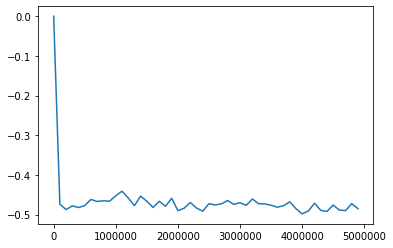

In [20]:
plt.plot([a[0] for a in trainning_info], [a[1] for a in trainning_info])

Все работает корректно - ошибка становится все более и более отрицательной, что эквивалентно увеличению вероятности корректных классов, если мы возьмем экспоненту от ошибки

In [0]:
representation_1 = model.fc1.weight.data.T
representation_2 = model.fc2.weight.data

In [0]:
total_coord = 0.5 * (representation_1 + representation_2)

In [0]:
from sklearn.decomposition import PCA

my_pca = PCA(n_components=2)

In [0]:
new_coord = my_pca.fit_transform(total_coord)

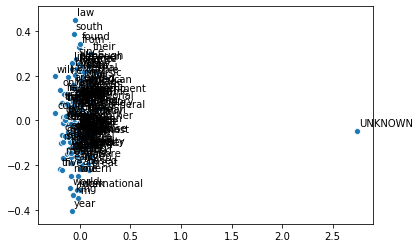

In [30]:
import seaborn as sns
from matplotlib.pyplot import figure

figure(figsize=(16, 12))

ax = sns.scatterplot(x=[a[0] for a in new_coord], y=[a[1] for a in new_coord])
for i in range(vocabulary_size):
    ax.text(new_coord[i][0]+.02, new_coord[i][1]+.02, ind2word[i])

Построим то же самое, но без UNKNOWN

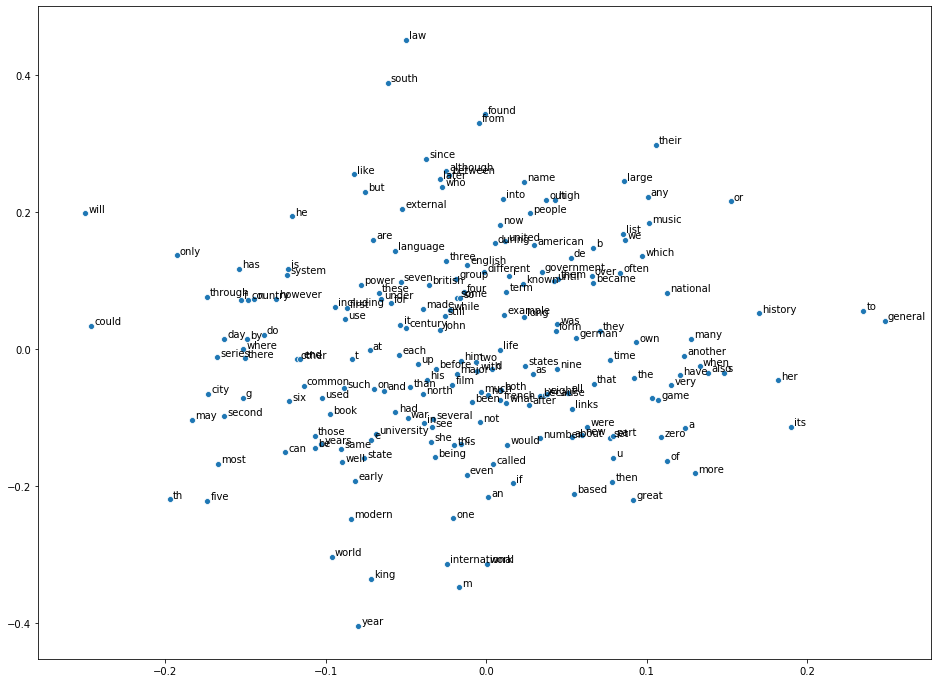

In [36]:
import seaborn as sns
from matplotlib.pyplot import figure

figure(figsize=(16, 12))

ax = sns.scatterplot(x=[a[0] for idx, a in enumerate(new_coord) \
                        if ind2word[idx] != 'UNKNOWN'], \
                     y=[a[1] for idx, a in enumerate(new_coord) \
                        if ind2word[idx] != 'UNKNOWN'])
for i in range(vocabulary_size - 1):
    if ind2word[i] != 'UNKNOWN':
        ax.text(new_coord[i][0]+.002, new_coord[i][1]+.002, ind2word[i])

Выглядит разумно, посмотрим на вывод t-SNE

In [0]:
from sklearn.manifold import TSNE

my_tsne = TSNE(n_components=2)

In [0]:
new_coord1 = my_tsne.fit_transform(total_coord)

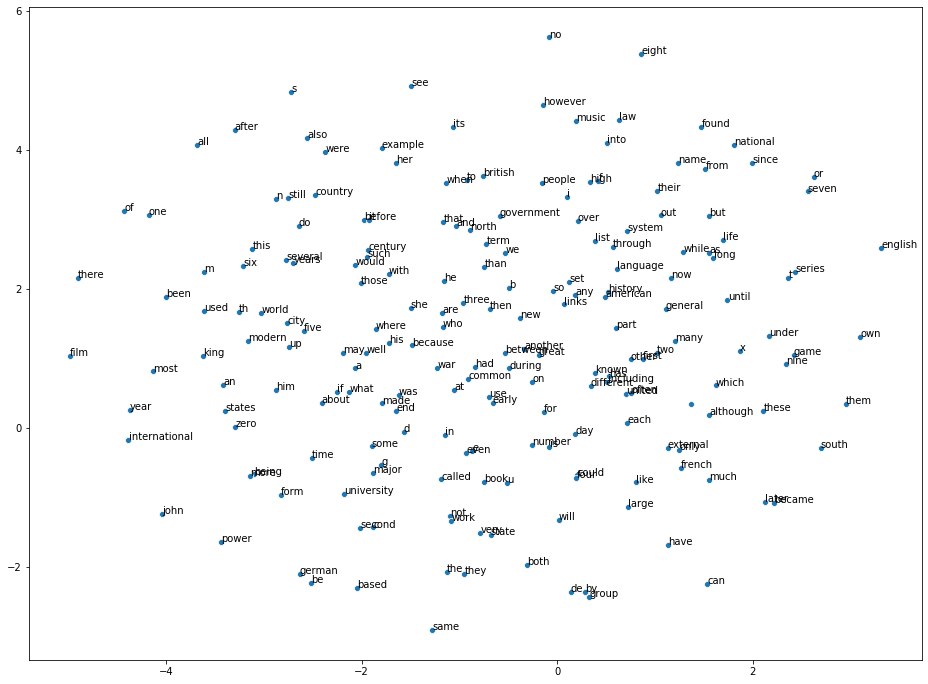

In [42]:
import seaborn as sns
from matplotlib.pyplot import figure

figure(figsize=(16, 12))

ax = sns.scatterplot(x=[a[0] for idx, a in enumerate(new_coord1) \
                        if ind2word[idx] != 'UNKNOWN'], \
                     y=[a[1] for idx, a in enumerate(new_coord1) \
                        if ind2word[idx] != 'UNKNOWN'])
for i in range(vocabulary_size - 1):
    if ind2word[i] != 'UNKNOWN':
        ax.text(new_coord1[i][0]+.002, new_coord1[i][1]+.002, ind2word[i])

Выглядит разумно